# Gausslet Demonstration
This notebook visualizes the gausslet basis built from the `G4.csv` coefficients.
It covers four quick diagnostics:
1. Plot a single scaled gausslet.
2. Visualize a grid of translated gausslets.
3. Check near-orthogonality via the overlap matrix.
4. Fit a random target function and report the reconstruction error.


In [6]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.parent != PROJECT_ROOT and not (PROJECT_ROOT / "codes").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

GAUSSLET_DIR = PROJECT_ROOT / "codes" / "gausslet"

from codes.gausslet.gausslet import gausslet_scaled, build_basis
from codes.gausslet.metrics import overlap_matrix
from codes.gausslet.fitting import project_onto_grid_gausslets, reconstruct_from_coeffs
from codes.gausslet.adaptive_gausslet import AdaptiveGaussletFitter

coeff_path = GAUSSLET_DIR / "coefficient" / "G4.csv"
arr = np.loadtxt(coeff_path, delimiter=",")
if arr.ndim == 1:
    b = arr.astype(float)
else:
    order = np.argsort(arr[:, 0])
    b = arr[order, 1].astype(float)

s = 3
centers = s * np.arange(-4, 5, 1, dtype=float)

def quadrature_half_width(centers, bcoef, s, pad_sigma=6.0):
    centers = np.asarray(centers, dtype=float)
    bcoef = np.asarray(bcoef, dtype=float)
    jmax = len(bcoef) - 1
    sigma_x = s / 3.0
    far_internal = (jmax / 3.0) * s
    return float(np.max(np.abs(centers)) + far_internal + pad_sigma * sigma_x)

print(f"Loaded {len(b)} gausslet coefficients from {coeff_path.name}")
print(f"Using scale s = {s} with {len(centers)} centers spanning [{centers[0]}, {centers[-1]}]")


Loaded 49 gausslet coefficients from G4.csv
Using scale s = 3 with 9 centers spanning [-12.0, 12.0]


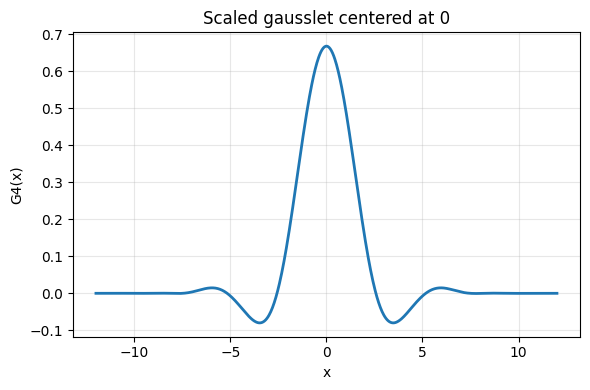

In [7]:
xx = np.linspace(-4 * s, 4 * s, 800)
yy = gausslet_scaled(xx, b, center=0.0, s=s)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(xx, yy, lw=2)
ax.set_title("Scaled gausslet centered at 0")
ax.set_xlabel("x")
ax.set_ylabel("G4(x)")
ax.grid(alpha=0.3)
fig.tight_layout()


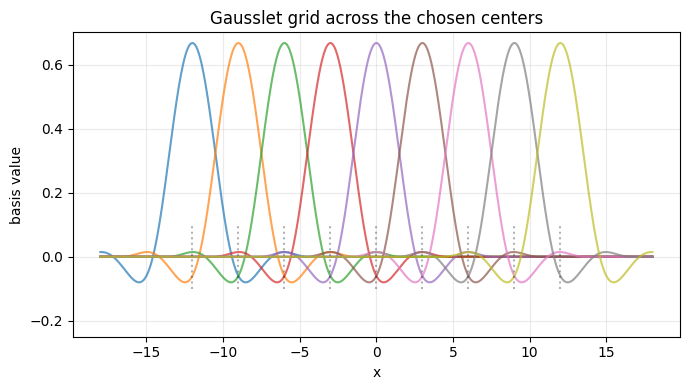

In [8]:
xx = np.linspace(centers[0] - 2 * s, centers[-1] + 2 * s, 1200)

fig, ax = plt.subplots(figsize=(7, 4))
for c in centers:
    ax.plot(xx, gausslet_scaled(xx, b, center=c, s=s), alpha=0.7)
ax.vlines(centers, ymin=-0.1, ymax=0.1, colors="k", linestyles=":", alpha=0.3)
ax.set_title("Gausslet grid across the chosen centers")
ax.set_xlabel("x")
ax.set_ylabel("basis value")
ax.set_ylim(-0.25, 1.05 * np.max(np.abs(gausslet_scaled(xx, b, center=0.0, s=s))))
ax.grid(alpha=0.25)
fig.tight_layout()


In [9]:
dx = s / 200.0
half_width = quadrature_half_width(centers, b, s)
xs = np.arange(-half_width, half_width + dx, dx)
basis = build_basis(centers, b, s=s)
S = overlap_matrix(basis, xs)

deviation = np.max(np.abs(S - np.eye(len(centers))))
print(f"Max |S - I| = {deviation:.2e}")
print(S)


Max |S - I| = 6.66e-16
[[ 1.00000000e+00  9.35350987e-17  6.93208205e-17 -1.13061435e-16
  -7.35116839e-17 -2.21678814e-17 -1.08877526e-16 -5.15887386e-17
  -2.19652775e-17]
 [ 8.65970514e-17  1.00000000e+00  8.73949774e-17  6.23047230e-17
  -1.12214269e-16 -7.37009597e-17 -2.21554550e-17 -1.08877735e-16
  -5.15888419e-17]
 [ 6.93206075e-17  8.73407677e-17  1.00000000e+00  7.38071865e-17
   6.91782621e-17 -1.11783741e-16 -7.35985365e-17 -2.21746900e-17
  -1.08875540e-16]
 [-1.12925910e-16  6.53385841e-17  6.68699887e-17  1.00000000e+00
   3.25284404e-17  8.02625124e-17 -1.12724664e-16 -7.36050022e-17
  -2.21617523e-17]
 [-7.34981313e-17 -1.12376899e-16  7.09214425e-17  4.64061984e-17
   1.00000000e+00  1.61232633e-16  7.49372960e-17 -1.11309983e-16
  -7.34633873e-17]
 [-2.21678550e-17 -7.37144824e-17 -1.11892108e-16  8.02625124e-17
   1.75110851e-16  1.00000000e+00  3.21612921e-17  7.53834423e-17
  -1.12828304e-16]
 [-1.08876996e-16 -2.21486523e-17 -7.35714315e-17 -1.12673845e-16
   7.

C:\Users\huihu\AppData\Local\Temp\ipykernel_3212\51133058.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz((f_true - f_fit) ** 2, xs_dense)
C:\Users\huihu\AppData\Local\Temp\ipykernel_3212\51133058.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ) / np.sqrt(np.trapz(f_true ** 2, xs_dense))


Used 41 basis functions; cond(S) ~ 1.10e+02
L2 error on the fitting grid: 1.534e+00
Relative L2 error on dense grid: 7.024e-01


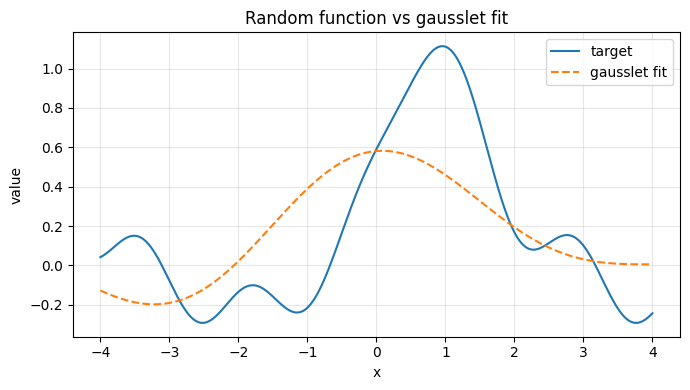

In [10]:
rng = np.random.default_rng(5)
amps = rng.normal(scale=0.5, size=4)
freqs = rng.integers(1, 5, size=4)
phases = rng.uniform(-np.pi, np.pi, size=4)

def target_function(x):
    x = np.asarray(x, dtype=float)
    bump = np.exp(-0.5 * ((x - 0.75) / 0.6) ** 2)
    harmonics = sum(a * np.sin(f * x + ph) for a, f, ph in zip(amps, freqs, phases))
    return bump + 0.3 * harmonics

interval = (-4.0, 4.0)
coeffs, fit_centers, cond_S, l2_error = project_onto_grid_gausslets(
    target_function,
    b,
    s=s,
    interval=interval,
    dx=s / 200.0,
    reg=1e-10,
)

xs_dense = np.linspace(interval[0], interval[1], 2000)
f_true = target_function(xs_dense)
f_fit = reconstruct_from_coeffs(xs_dense, coeffs, fit_centers, b, s=s)

rel_l2 = np.sqrt(
    np.trapz((f_true - f_fit) ** 2, xs_dense)
) / np.sqrt(np.trapz(f_true ** 2, xs_dense))

print(f"Used {len(fit_centers)} basis functions; cond(S) ~ {cond_S:.2e}")
print(f"L2 error on the fitting grid: {l2_error:.3e}")
print(f"Relative L2 error on dense grid: {rel_l2:.3e}")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(xs_dense, f_true, label="target")
ax.plot(xs_dense, f_fit, linestyle="--", label="gausslet fit")
ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("Random function vs gausslet fit")
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()

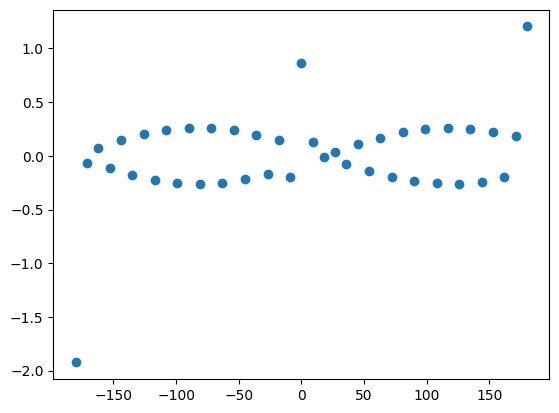

In [11]:
plt.scatter(fit_centers*s, coeffs)


total atoms: 229, residual RMS: 1.145e-04
  level j=0: 41 atoms
  level j=1: 14 atoms
  level j=2: 26 atoms
  level j=3: 50 atoms
  level j=4: 98 atoms


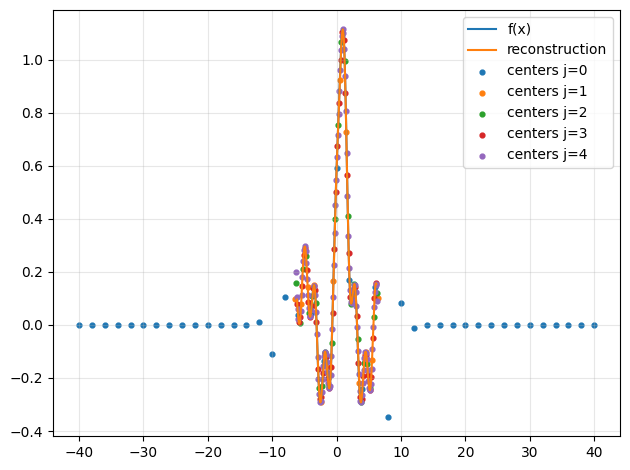

In [12]:
fitter = AdaptiveGaussletFitter(
        bcoef=b, interval=interval, s0=2.0,
        J_min=0, J_max=4, dx=None, pad_sigma=4.0,
        reg=1e-8, refine_factor=0.9, max_iters=6
    )
res = fitter.fit(target_function)
print(res.summary())

xs = res.xs
xx = np.linspace(interval[0], interval[1], 100)
plt.plot(xx, target_function(xx), label="f(x)")
plt.plot(xs, res.evaluate(xs, b), label="reconstruction")
# 标出不同层的中心
for j, cnt in res.per_level_counts.items():
    cs = [a.c for a in res.atoms if a.j == j]
    ys = res.evaluate(np.array(cs), b)
    plt.scatter(cs, ys, s=12, label=f"centers j={j}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()